# Self-Driving Car Engineer Nanodegree
## Project: Vehicle Detection and Tracking


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

## Features extraction

Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

### The `extract_features` function extracl all nessesary features from images. It also augment the train dataset by horizontal image flipping.

In [4]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

## Data loading
Here we create lists of [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images provided by Udacity. Corrisponding folders contain unzilled archives.

In [5]:
car_images = glob.glob('vehicles/vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


### Visualize Some of the Data

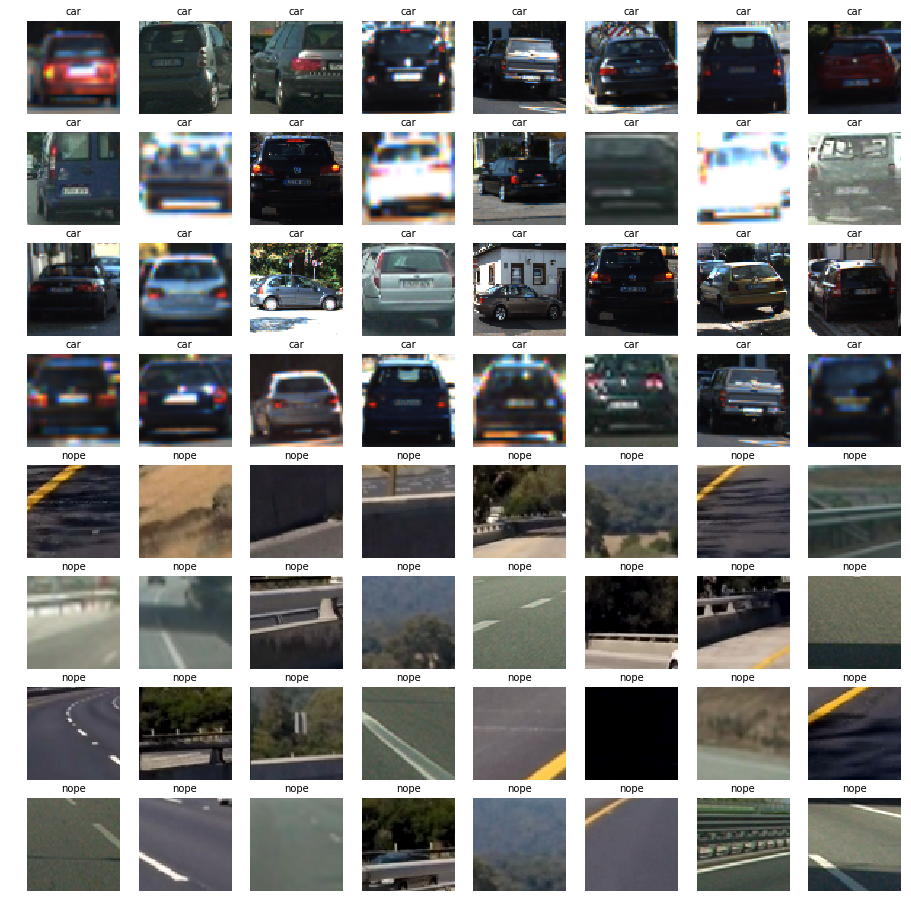

In [6]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

## Classifier

The following code chunk creates feature list for the training data. Feature list is normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into thaining and testing subsets (80% and 20%).


The classifier (Linear SVM) is trained there as well. 

In [7]:
# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

/home/ashutosh/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car samples:  17584
Notcar samples:  17936
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
10.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9878


## Slide window

Here we define a sliding window function `slide_window` to generate a list of boxes with predefined parameters and a `draw_boxes` to draw the list of boxes on an image.
These and some of the following functions are from the Udacity's lectures because they just work and perform useful tasks.

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
  
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [9]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


In [10]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

### Classifier test

Here we test the calssifier on the test images

/home/ashutosh/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1859.79 Seconds to process test images


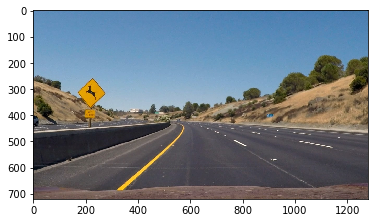

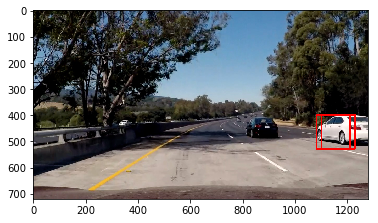

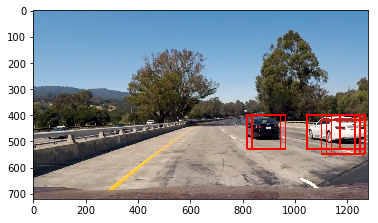

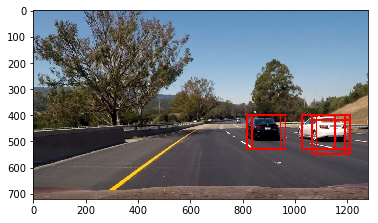

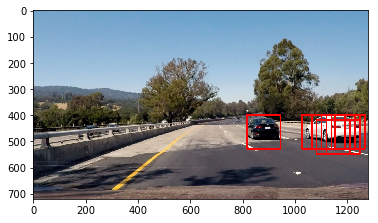

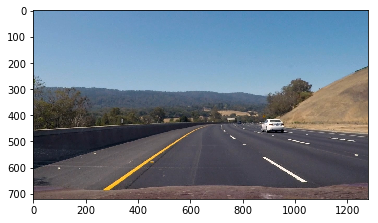

In [12]:
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

### Combine Various Sliding Window Searches

/home/ashutosh/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


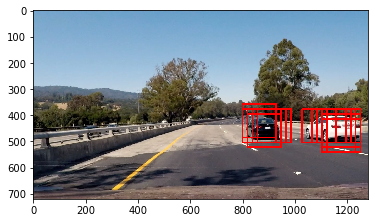

In [13]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell =8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel =0# Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


#test_img = mpimg.imread('./test_images/test1.jpg')
test_img = cv2.imread('./test_images/test4.jpg')
rectangles = []
hot_windows = []


xstart=0
xstop=700
ystart = 300
ystop = 550
scale = 1

windows = slide_window(test_img, x_start_stop=[xstart, xstop], y_start_stop=[ystart, ystop], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
rectangles=rectangles+windows
hot_windows += (search_windows(test_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))   
#print(windows)
#print(hot_windows)

xstart=800
xstop=None
ystart = 300
ystop = 700
scale = 1.0

windows = slide_window(test_img, x_start_stop=[xstart, xstop], y_start_stop=[ystart, ystop], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
rectangles=rectangles+windows
hot_windows += (search_windows(test_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))   


#print(hot_windows)
window_img = draw_boxes(test_img, hot_windows, color=(0, 0, 255), thick=6)                    
show_img(window_img)

## Advanced Sliding Windows

To increase performance we need to analize the smallest possible number of windows. That is why, we will scan with a search window not across the whole image, but only areas where a new car can appear and also we are going to scan areas where a car was detected (track cars). 
### Detect new cars
On every frame we look for new passing cars (red areas on sides) cars and new far cars (blue area).

In [14]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


...


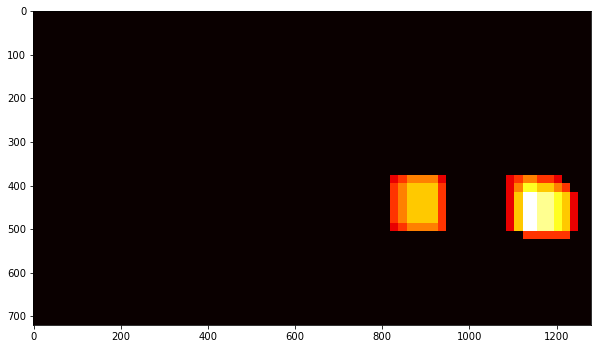

In [16]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, hot_windows)
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

### Apply SciPy Labels to Heatmap

2 cars found


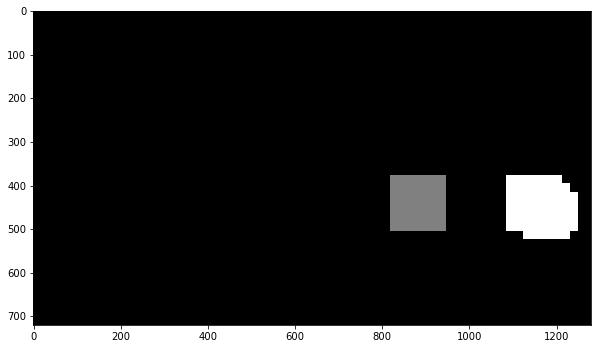

In [17]:
from scipy.ndimage.measurements import label

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

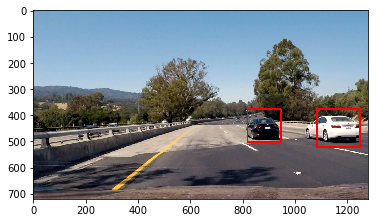

In [18]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
show_img(draw_img)

### Put it All Together

In [19]:
#global history of bounding boxes
#generate bounding box only if it was there in last n images
global prevRects 
prevRects= []



In [20]:
def process_frame(img, readImage=False, Convert= False, historyBoxes=True):

    if readImage : 
        image = cv2.imread(img)
    else:
         image =img
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[800, None], y_start_stop=[400, 640], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))        
    heatmap_img = np.zeros_like(image[:,:,0])
    #heatmap_img = add_heat(heatmap_img, hot_windows)
    
    global prevRects
    
    if not historyBoxes:
        prevRects=[]
        
    prevRects.append(hot_windows)
    if len(prevRects) > 20:
            # throw out oldest rectangle set(s)
            prevRects = prevRects[len(prevRects)-5:]
            
    for rect_set in prevRects:
        heatmap_img = add_heat(heatmap_img, rect_set)
        
    if historyBoxes:
        heatmap_img = apply_threshold(heatmap_img, 30)
    
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(image), labels)
    if Convert:
        draw_img=cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    return draw_img

print('...')

...


/home/ashutosh/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


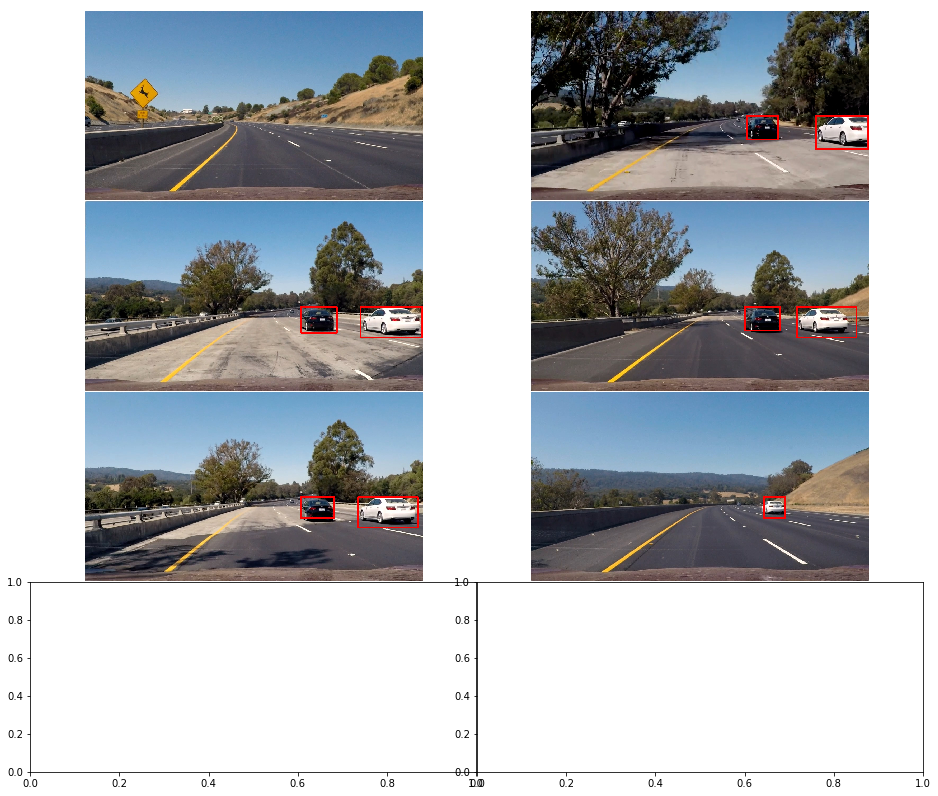

In [22]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(4, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(im, True, True, False))
    axs[i].axis('off')



### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./test_video_out.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes
.
We have calculated different size of bounding boxes and then apply svm classifier to detect images within that. Then as per lectures we draw heat maps and from heat maps we have drawn max and min bounding boxes.  Same logic is implemented as process function which takes eachimage from video frame.  We can improve this pipeline By using RCNN which is already implemented in DARKNET YOLO to detect objects from videos in real time. SVM based classification is also doing pretty well in real time . 


In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
prevRects= []
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:11<00:02,  2.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 10s, sys: 156 ms, total: 1min 11s
Wall time: 1min 11s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [26]:

prevRects= []
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
clip_proj = clip_proj.subclip(0, 2)
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


 98%|█████████▊| 50/51 [01:28<00:01,  1.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1min 28s, sys: 108 ms, total: 1min 28s
Wall time: 1min 29s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))